In [1]:
import numpy as np
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch.nn as nn
import torch.nn.functional as F


import trimesh

from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

In [2]:
# *_*coding:utf-8 *_*
import torch
import os
import json
import warnings
import numpy as np
from torch.utils.data import Dataset
warnings.filterwarnings('ignore')

def pc_normalize(pc):
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc ** 2, axis=1)))
    pc = pc / m
    return pc

#['Airplane', 'Bag', 'Cap', 'Car', 'Chair', 'Earphone','Guitar', 'Knife', 'Lamp', 'Laptop', 'Motorbike', 'Mug', 'Pistol', 'Rocket', 'Skateboard', 'Table']
class PartNormalDataset(Dataset):
    def __init__(self,root = './shapenetcore_partanno_segmentation_benchmark_v0', npoints=2048, split='train', class_choice=['Airplane', 'Bag', 'Cap', 'Car', 'Chair', 'Earphone','Guitar', 'Knife', 'Lamp', 'Laptop'], normal_channel=False):
        self.npoints = npoints
        self.root = root
        self.catfile = os.path.join(self.root, 'synsetoffset2category.txt')
        self.cat = {}
        self.normal_channel = normal_channel


        with open(self.catfile, 'r') as f:
            for line in f:
                ls = line.strip().split()
                self.cat[ls[0]] = ls[1]
        self.cat = {k: v for k, v in self.cat.items()}
        self.classes_original = dict(zip(self.cat, range(len(self.cat))))
        if not class_choice is  None:
            self.cat = {k:v for k,v in self.cat.items() if k in class_choice}

        self.meta = {}
        with open(os.path.join(self.root, 'train_test_split', 'shuffled_train_file_list.json'), 'r') as f:
            train_ids = set([str(d.split('/')[2]) for d in json.load(f)])
        with open(os.path.join(self.root, 'train_test_split', 'shuffled_val_file_list.json'), 'r') as f:
            val_ids = set([str(d.split('/')[2]) for d in json.load(f)])
        with open(os.path.join(self.root, 'train_test_split', 'shuffled_test_file_list.json'), 'r') as f:
            test_ids = set([str(d.split('/')[2]) for d in json.load(f)])
        
        
        for item in self.cat:
            #print('category', item)
            self.meta[item] = []
            dir_point = os.path.join(self.root, self.cat[item])
            dir_point = os.path.join(dir_point, 'points')
            #print(self.cat[item])
            fns = sorted(os.listdir(dir_point))
            
            #print(fns[0][0:-4])
            if split == 'trainval':
                fns = [fn for fn in fns if ((fn[0:-4] in train_ids) or (fn[0:-4] in val_ids))]
            elif split == 'train':
                fns = [fn for fn in fns if fn[0:-4] in train_ids]
            elif split == 'val':
                fns = [fn for fn in fns if fn[0:-4] in val_ids]
            elif split == 'test':
                fns = [fn for fn in fns if fn[0:-4] in test_ids]
            else:
                print('Unknown split: %s. Exiting..' % (split))
                exit(-1)


            for fn in fns:
                token = (os.path.splitext(os.path.basename(fn))[0])
                self.meta[item].append(os.path.join(dir_point, token + '.pts'))

        self.datapath = []
        for item in self.cat:
            for fn in self.meta[item]:
                self.datapath.append((item, fn))
        
        self.meta2 = {}
        for item in self.cat:
            #print('category', item)
            self.meta2[item] = []
            dir_point = os.path.join(self.root, self.cat[item])
            dir_point = os.path.join(dir_point, 'points_label')
            #print(self.cat[item])
            fns = sorted(os.listdir(dir_point))

            #print(fns[0][0:-4])
            if split == 'trainval':
                fns = [fn for fn in fns if ((fn[0:-4] in train_ids) or (fn[0:-4] in val_ids))]
            elif split == 'train':
                fns = [fn for fn in fns if fn[0:-4] in train_ids]
            elif split == 'val':
                fns = [fn for fn in fns if fn[0:-4] in val_ids]
            elif split == 'test':
                fns = [fn for fn in fns if fn[0:-4] in test_ids]
            else:
                print('Unknown split: %s. Exiting..' % (split))
                exit(-1)


            for fn in fns:
                token = (os.path.splitext(os.path.basename(fn))[0])
                self.meta2[item].append(os.path.join(dir_point, token + '.seg'))
        self.datapath2 = []
        for item in self.cat:
            for fn in self.meta2[item]:
                self.datapath2.append((item, fn))

        self.classes = {}
        for i in self.cat.keys():
            self.classes[i] = self.classes_original[i]

        # Mapping from category ('Chair') to a list of int [10,11,12,13] as segmentation labels
        self.seg_classes = {'Earphone': [16, 17, 18], 'Motorbike': [30, 31, 32, 33, 34, 35], 'Rocket': [41, 42, 43],
                            'Car': [8, 9, 10, 11], 'Laptop': [28, 29], 'Cap': [6, 7], 'Skateboard': [44, 45, 46],
                            'Mug': [36, 37], 'Guitar': [19, 20, 21], 'Bag': [4, 5], 'Lamp': [24, 25, 26, 27],
                            'Table': [47, 48, 49], 'Airplane': [0, 1, 2, 3], 'Pistol': [38, 39, 40],
                            'Chair': [12, 13, 14, 15], 'Knife': [22, 23]}

        self.cache = {}  # from index to (point_set, cls, seg) tuple
        self.cache_size = 20000


    def __getitem__(self, index):
        if index in self.cache:
            point_set, cls, seg = self.cache[index]
        else:
            fn = self.datapath[index]
            #print(fn)
            cat = self.datapath[index][0]
            cls = self.classes[cat]
            data = np.loadtxt(fn[1]).astype(np.float32)
            fn2 = self.datapath2[index]
            data2 = np.loadtxt(fn2[1]).astype(np.float32)
            if not self.normal_channel:
                point_set = data[:, 0:3]
            else:
                point_set = data[:, 0:6]
            seg = data2.astype(int)
            
            if len(self.cache) < self.cache_size:
                self.cache[index] = (point_set, cls, seg)
                
        point_set[:, 0:3] = pc_normalize(point_set[:, 0:3])

        choice = np.random.choice(len(seg), self.npoints, replace=True)
        
        # resample
        
        point_set = point_set[choice, :]
        seg = seg[choice]

        return point_set, cls, seg

    def __len__(self):
        return len(self.datapath)
    
    def get_map(self):
        return self.classes



TRAIN_DATASET = PartNormalDataset(split='train')
print(len(TRAIN_DATASET))

print(TRAIN_DATASET.get_map())
trainDataLoader = torch.utils.data.DataLoader(TRAIN_DATASET, batch_size=10, shuffle=True, num_workers=10, drop_last=True)
TEST_DATASET = PartNormalDataset(split='test')
testDataLoader = torch.utils.data.DataLoader(TEST_DATASET, batch_size=10, shuffle=False, num_workers=10)
print("The number of training data is: %d" % len(TRAIN_DATASET))
print("The number of test data is: %d" % len(TEST_DATASET))
print(TRAIN_DATASET[0])



7686
{'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9}
The number of training data is: 7686
The number of test data is: 1850
(array([[ 0.20091861,  0.0701225 , -0.03245486],
       [-0.22294837,  0.03267804, -0.19775446],
       [ 0.48385373,  0.07424331,  0.01746194],
       ...,
       [ 0.11531556, -0.18479106, -0.2595667 ],
       [ 0.10026085, -0.03567253, -0.9018918 ],
       [ 0.17814423, -0.05449092,  0.59311223]], dtype=float32), 0, array([1, 4, 1, ..., 2, 2, 2]))


In [3]:
#set active device to 'cpu' or 'gpu', look for "torch.cuda.is_available()"
if(torch.cuda.is_available()):
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(device)

#define hyper-parameters
num_points = 2048
num_classes = 10
batch_size = 25

cuda


4


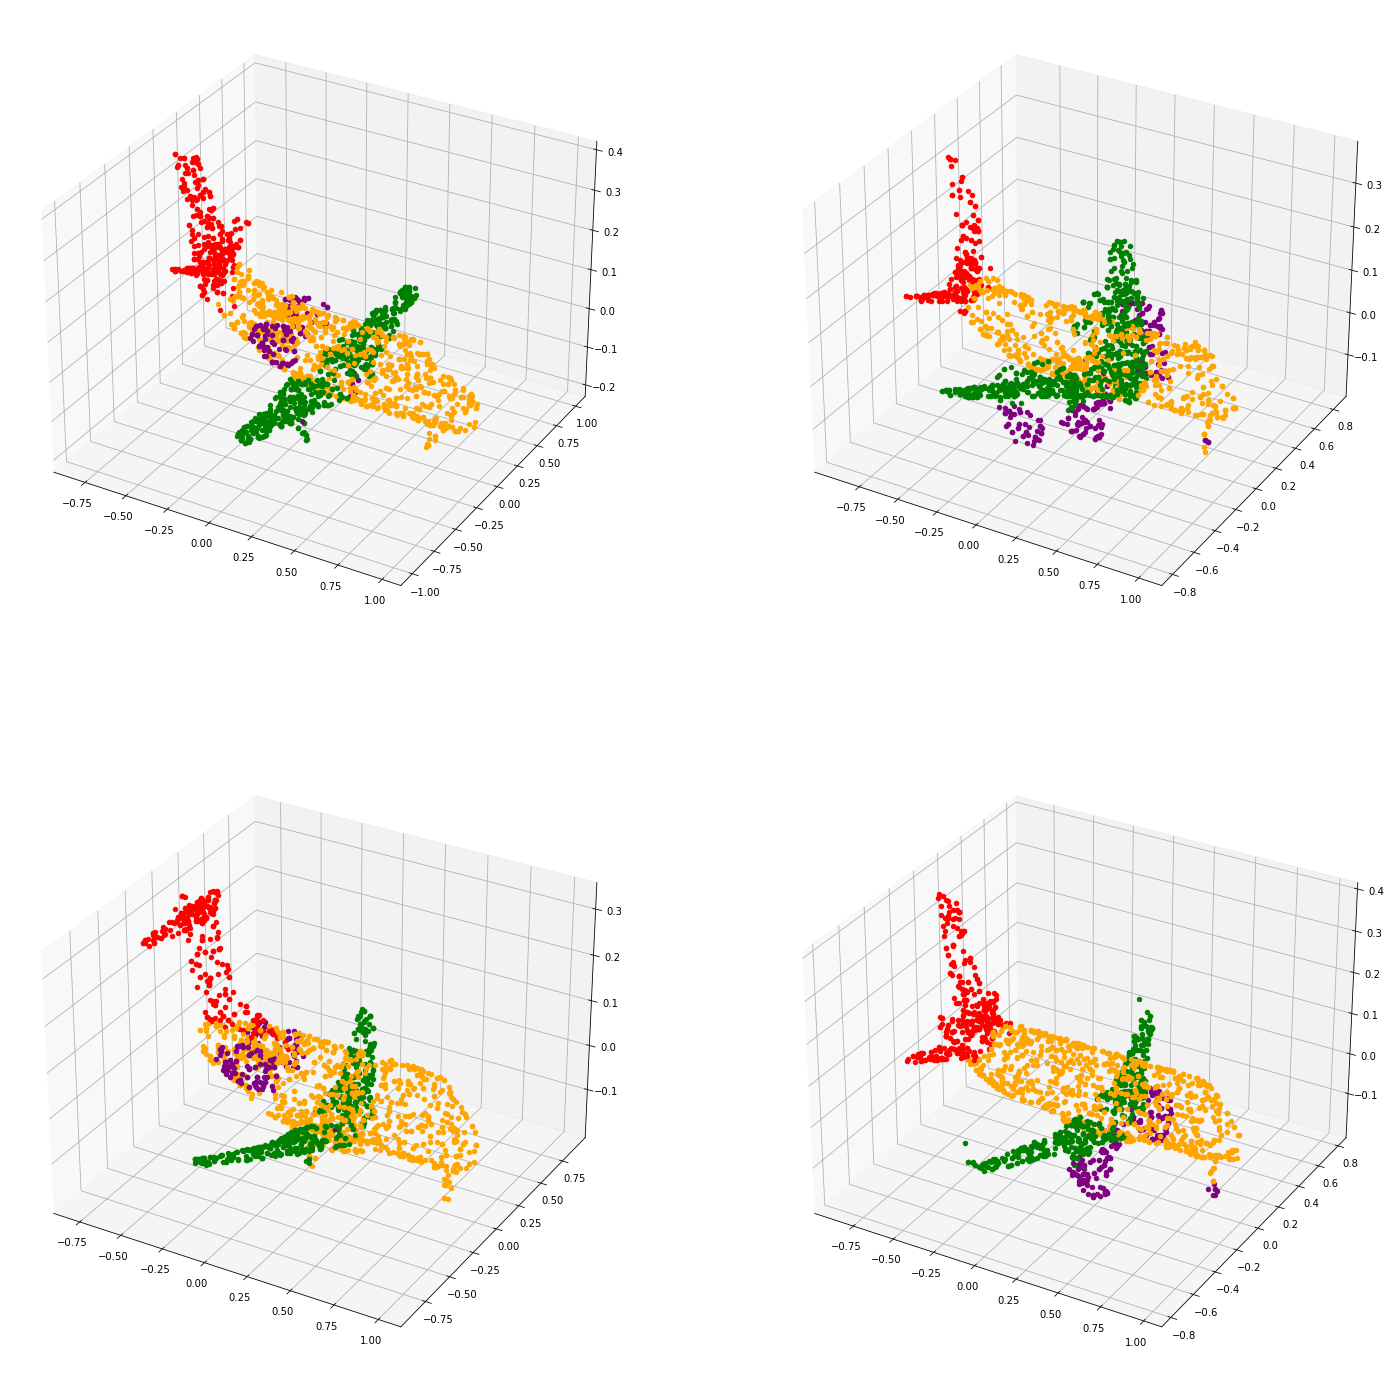

In [4]:
from matplotlib import pyplot as plt
data = [TRAIN_DATASET[i] for i in range(4)]
print(len(data))
seg_points = [data[i][2] for i in range(4)]

color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']
points = [data[i][0] for i in range(4)]

fig = plt.figure(figsize=(25, 25))
for j in range(4):
    obj = points[j]
    ax = fig.add_subplot(2, 2, j + 1, projection="3d")
    for i in range(2048):
        ax.scatter(obj[i][0], obj[i][2], obj[i][1], color = color[seg_points[j][i]])

plt.show()

In [ ]:
CLASS_MAP = TRAIN_DATASET.get_map()
print(CLASS_MAP)
train_data = np.array(TRAIN_DATASET)
test_data = np.array(TEST_DATASET)
print(train_data.shape)

{'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9}


In [8]:
train_points, train_label, train_feat = train_data[:,[0]], train_data[:,[1]], train_data[:,[2]]

train_points = torch.as_tensor([train_points[i][0] for i in range(len(train_points))], dtype = float)

train_labels = [0]*len(train_label)
for i in range(len(train_label)):
    train_labels[i] = train_label[i][0]

train_feats = []
for i in range(len(train_feat)):
    train_feats.append(list(train_feat[i][0]))
train_points = torch.transpose(train_points,1,2)

train_labels = torch.as_tensor(train_labels)
train_feats = torch.tensor(train_feats)


print(train_points.shape, train_labels.shape, train_feats.shape)

test_points, test_label, test_feat = test_data[:,[0]], test_data[:,[1]], test_data[:,[2]]
test_points = torch.as_tensor([test_points[i][0] for i in range(len(test_points))], dtype = float)
test_points = torch.transpose(test_points,1,2)

test_labels = [0]*len(test_label)
for i in range(len(test_label)):
    test_labels[i] = test_label[i][0]

test_feats = []
for i in range(len(test_feat)):
    test_feats.append(list(test_feat[i][0]))
    
test_labels = torch.as_tensor(test_labels)
test_feats = torch.as_tensor(test_feats)




torch.save(train_points, '2train_points.pt')
torch.save(test_points, '2test_points.pt')
torch.save(train_labels, '2train_labels.pt')
torch.save(test_labels, '2test_labels.pt')
torch.save(train_feats, '2train_feats.pt')
torch.save(test_feats, '2test_feats.pt')

torch.Size([7686, 3, 2048]) torch.Size([7686]) torch.Size([7686, 2048])


In [4]:
train_points = torch.load('2train_points.pt')
test_points = torch.load('2test_points.pt')
train_labels = torch.load('2train_labels.pt')
test_labels = torch.load('2test_labels.pt')
train_feats = torch.load('2train_feats.pt')
test_feats = torch.load('2test_feats.pt')
print(test_points.shape, test_labels.shape, test_feats.shape)

idx = np.random.permutation(train_points.size(0))
train_points,train_labels,train_feats = train_points[idx], train_labels[idx], train_feats[idx]
idx = np.random.permutation(test_points.size(0))
test_points,test_labels,test_feats = test_points[idx], test_labels[idx], test_feats[idx]


torch.Size([1850, 3, 2048]) torch.Size([1850]) torch.Size([1850, 2048])


In [5]:
class TNet(nn.Module):
    def __init__(self, n_sample, n_feature):
        super(TNet, self).__init__()
        self.n_sample = n_sample
        self.n_feature = n_feature
        
        self.mlp1 = nn.Sequential(
            nn.Conv1d(n_feature, 64, kernel_size = 1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(True),
            nn.Conv1d(64, 128, kernel_size = 1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(True),
            nn.Conv1d(128, 1024, kernel_size = 1),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(True)
            
        )
        


        self.mlp2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(512),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(256),
            nn.Linear(256, n_feature * n_feature)
        )

    def forward(self, x):
      x = x.float()
      input = x
      x = self.mlp1(x)
      x = nn.MaxPool1d(self.n_sample)(x)
      x = torch.flatten(x, start_dim = 1)
      x = self.mlp2(x)
      x = x.reshape((x.size(0), self.n_feature, self.n_feature))
      x = x @ input
      return x

In [6]:
class PointNet(nn.Module):
  def __init__(self, n_sample, n_classes):
      super(PointNet, self).__init__()
        
      self.n_sample = n_sample
    
      self.mlp64 = nn.Sequential(
          nn.Conv1d(3, 64, kernel_size = 1),
          nn.BatchNorm1d(64),
          nn.ReLU(True),
      )

      self.mlp1024 = nn.Sequential(
          nn.Conv1d(64, 128, kernel_size = 1),
          nn.BatchNorm1d(128),
          nn.LeakyReLU(True),
          nn.Conv1d(128, 1024, kernel_size = 1),
          nn.BatchNorm1d(1024),
          nn.LeakyReLU(True)
      )

      self.mlpk = nn.Sequential(
          nn.Linear(1024, 512),
          nn.BatchNorm1d(512),
          nn.LeakyReLU(True),
          nn.Linear(512, 256),
          nn.BatchNorm1d(256),
          nn.LeakyReLU(True),
          nn.Linear(256, n_classes),
          nn.Softmax(dim = -1)
      )

      self.t3 = TNet(n_sample, 3)

      self.t64 = TNet(n_sample, 64)

      self.fc1 = nn.Sequential(nn.Linear(1088, 512))
      self.fc2 = nn.Sequential(nn.Linear(512, 256))
      self.fc3 = nn.Sequential(nn.Linear(256, 128))
      self.fc4 = nn.Sequential(nn.Linear(128, 5), nn.Softmax(dim = -1)) #here we choose 10 features
      
      self.bn1 = nn.Sequential(nn.BatchNorm1d(512), nn.LeakyReLU(True))
      self.bn2 = nn.Sequential(nn.BatchNorm1d(256), nn.LeakyReLU(True))
      self.bn3 = nn.Sequential(nn.BatchNorm1d(128), nn.LeakyReLU(True))
    
  def forward2(self, x):

    x = x.float()
    x = self.t3.forward(x)
    x = self.mlp64(x)
    x = self.t64.forward(x)
    
    feat_map64 = x
    
    x = self.mlp1024(x)
    x = nn.MaxPool1d(self.n_sample)(x)
    x = torch.flatten(x, start_dim = 1)
    
    glob_feat = x
    
    x = self.mlpk(x)
    
    glob_feat = torch.unsqueeze(glob_feat, -1)
    glob_feat = glob_feat.repeat(1, 1, self.n_sample)
    feat_map = torch.cat((feat_map64, glob_feat), dim = 1)
    feat_map = feat_map.transpose(1,2)
    feat_map = self.fc1(feat_map)
    feat_map = feat_map.transpose(1,2)
    feat_map = self.bn1(feat_map)
    feat_map = feat_map.transpose(1,2)
    feat_map = self.fc2(feat_map)
    feat_map = feat_map.transpose(1,2)
    feat_map = self.bn2(feat_map)
    feat_map = feat_map.transpose(1,2)
    feat_map = self.fc3(feat_map)
    feat_map = feat_map.transpose(1,2)
    feat_map = self.bn3(feat_map)
    feat_map = feat_map.transpose(1,2)
    feat_map = self.fc4(feat_map)
    return x, feat_map



In [7]:
pointnet = PointNet(2048, num_classes)
pointnet.to(device)

PointNet(
  (mlp64): Sequential(
    (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (mlp1024): Sequential(
    (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
  )
  (mlpk): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(ne

In [8]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.01)

In [9]:
def training(train_points,train_labels, train_feats, device, optimizer, test_points, test_labels, test_feats):
# Set our network to the training model.
    pointnet.train()
# Init the train loss, total data and number corrected predictions.
    train_loss = 0
    total_data = 0
    prediction = 0
    data_size1 = 0
    num_corr_predictions1 = 0
    total_datasize1 = 0
    train_seg_loss = 0
    

# For each data in the training split
    for i in range(0, len(train_labels) - batch_size, batch_size):
        data = train_points[i:i+batch_size]
        value = train_labels[i:i+batch_size].long()
        feat = train_feats[i:i+batch_size].long()
        corr_pred1 = 0

# Put the data to the correct devices using .to()
        data = data.to(device)
        value = value.to(device)
        feat = feat.to(device)
        
# Reset the gradient of the optimzier.
        optimizer.zero_grad()      
# Feed the data forward to the google net
        temp = pointnet.forward2(data)
        forwarded_data = temp[0]
        feat_map = temp[1]
        
    
        #print(value, forwarded_data)
# Use the criterion function to compute the loss term            
        seg_ls = 0
        for i in range(len(feat_map)):
            seg_ls += criterion(feat_map[i], feat[i])
        loss = criterion(forwarded_data, value) + seg_ls
        #print('loss is', loss)

# Backprop the loss
        loss.backward()
    
        # Update the network parameters using the optimzier
        # try optimizer.step(closure) from https://pytorch.org/docs/stable/optim.html
        optimizer.step()
    
        # Accumulate the training loss
        train_loss += loss.item()
        train_seg_loss += seg_ls.item()
    

# Find the prediciton. hint: using torch.max() 
        max_elements, max_idxs = torch.max(feat_map, dim = 2)
        seg_points = max_idxs
        max_elements, max_idxs = torch.max(forwarded_data, dim = 1)
        prediction = max_idxs 
        
# Increment the data size
        data_size = value.size(0)
        total_datasize1 += data_size
#     # Increment the corrected prediction
        for i in range(data_size):
            if prediction[i]==value[i]:
                num_corr_predictions1 += 1

                    
        
    
                
    
##     TESTING   
# Set our network to the test model.
    pointnet.eval()
    # Init the 
    test_loss = 0
    total_data = 0 
    num_corr_predictions = 0
    test_seg_loss = 0

    
    data_size = 0
    total_datasize = 0
    Pred_test = 0

    # For each data in the training split, we warp it using torch.no_grad()

    with torch.no_grad():        
        for i in range(0,len(test_labels) - batch_size, batch_size):
            data = test_points[i: i + batch_size]
            value = test_labels[i:i + batch_size].long()
            feat = test_feats[i:i+batch_size].long()

            
    # Put the data to the correct devices using .to()
            data = data.to(device)
            value = value.to(device)
            feat = feat.to(device)

    # Feed the data forward to the google net
            temp = pointnet.forward2(data)
            forwarded_data = temp[0]
            feat_map = temp[1]


    # Use the criterion function to compute the loss term
            seg_ls = 0
            for i in range(len(feat_map)):
                seg_ls += criterion(feat_map[i], feat[i])
            loss = criterion(forwarded_data, value) + seg_ls

            
    # Accumulate the testing loss
            test_loss += loss.item()
            test_seg_loss += seg_ls.item()
            
    # Find the prediciton. hint: using torch.max()
            max_elements, max_idxs = torch.max(forwarded_data, dim = 1)
            prediction = max_idxs


#     Increment the data size
            data_size = value.size(0)
            total_datasize += data_size
#     # Increment the corrected prediction
            corr_pred = 0
            for i in range(data_size):
                if prediction[i]==value[i]:
                    #increment number of correct predictions (corr_pred)
                    corr_pred += 1
                    
            #increment num_corr_predictions by corr_pred
            num_corr_predictions += corr_pred

    training_acc = num_corr_predictions1/total_datasize1

    testing_acc = num_corr_predictions/total_datasize
    
    return training_acc, testing_acc, train_loss, test_loss, train_seg_loss, test_seg_loss



In [10]:
#Train and Test the DNN model

AllTestAcc = []
AllTrainAcc = []
LossTrain = []
LossTest = []

epoches = 10 #change to 25 later
# For each epoch:
for ep in range(epoches):

# we train and test our module
    training_acc, testing_acc, train_loss, test_loss, train_seg_loss, test_seg_loss = training(train_points, train_labels, train_feats, device, optimizer, test_points, test_labels, test_feats)
# we update the testing accuracy
    AllTestAcc.append(testing_acc)
    AllTrainAcc.append(training_acc)
    LossTrain.append(train_loss)
    LossTest.append(test_loss)
    
    training_acc = training_acc*100
    testing_acc = testing_acc*100
    print('Epoch ',ep)
    print('Training accuracy is:', ("%.4g" % training_acc) ,'%, ', 'Testing accuracy:', ("%.4g" % testing_acc),'%')
    
    print('Training loss is:', train_loss , 'Testing loss is:',test_loss)
    print('Training seg loss is:', train_seg_loss , 'Testing seg loss is:',test_seg_loss)
# we save the module at the end and print the accuracy
# we first step our scheduler
    scheduler.step()

Epoch  0
Training accuracy is: 83.44 %,  Testing accuracy: 83.73 %
Training loss is: 9906.371604919434 Testing loss is: 2227.4014778137207
Training seg loss is: 9404.788663864136 Testing seg loss is: 2108.3396224975586
Epoch  1
Training accuracy is: 88.65 %,  Testing accuracy: 88.44 %
Training loss is: 9316.459150314331 Testing loss is: 2185.7710285186768
Training seg loss is: 8832.536033630371 Testing seg loss is: 2070.509641647339
Epoch  2
Training accuracy is: 89.95 %,  Testing accuracy: 93.75 %
Training loss is: 9104.18426322937 Testing loss is: 2119.943920135498
Training seg loss is: 8624.572053909302 Testing seg loss is: 2008.5827236175537
Epoch  3
Training accuracy is: 92.76 %,  Testing accuracy: 91.84 %
Training loss is: 8955.602422714233 Testing loss is: 2116.6270999908447
Training seg loss is: 8484.173782348633 Testing seg loss is: 2003.9401321411133
Epoch  4
Training accuracy is: 93.28 %,  Testing accuracy: 93.48 %
Training loss is: 8883.464637756348 Testing loss is: 2103.35

In [42]:
points = test_points[:20].to(device)
labels = test_labels[:20].to(device)
feats = test_feats[:20].to(device)


forwarded_data, feat_map = pointnet.forward2(points)
max_elements, max_idxs = torch.max(forwarded_data, dim = 1)
preds = max_idxs
print(preds)
print(labels)

tensor([4, 4, 7, 0, 6, 4, 8, 8, 7, 8, 8, 4, 4, 8, 0, 0, 0, 4, 0, 0],
       device='cuda:0')
tensor([4, 4, 7, 0, 6, 4, 8, 8, 7, 8, 8, 4, 4, 1, 8, 0, 0, 4, 0, 0],
       device='cuda:0')


In [45]:
CLASS_MAP = {v: k for k, v in CLASS_MAP.items()}
print(CLASS_MAP)

{0: 'Airplane', 1: 'Bag', 2: 'Cap', 3: 'Car', 4: 'Chair', 5: 'Earphone', 6: 'Guitar', 7: 'Knife', 8: 'Lamp', 9: 'Laptop'}


average segmentation accuracy is:  78.27 %


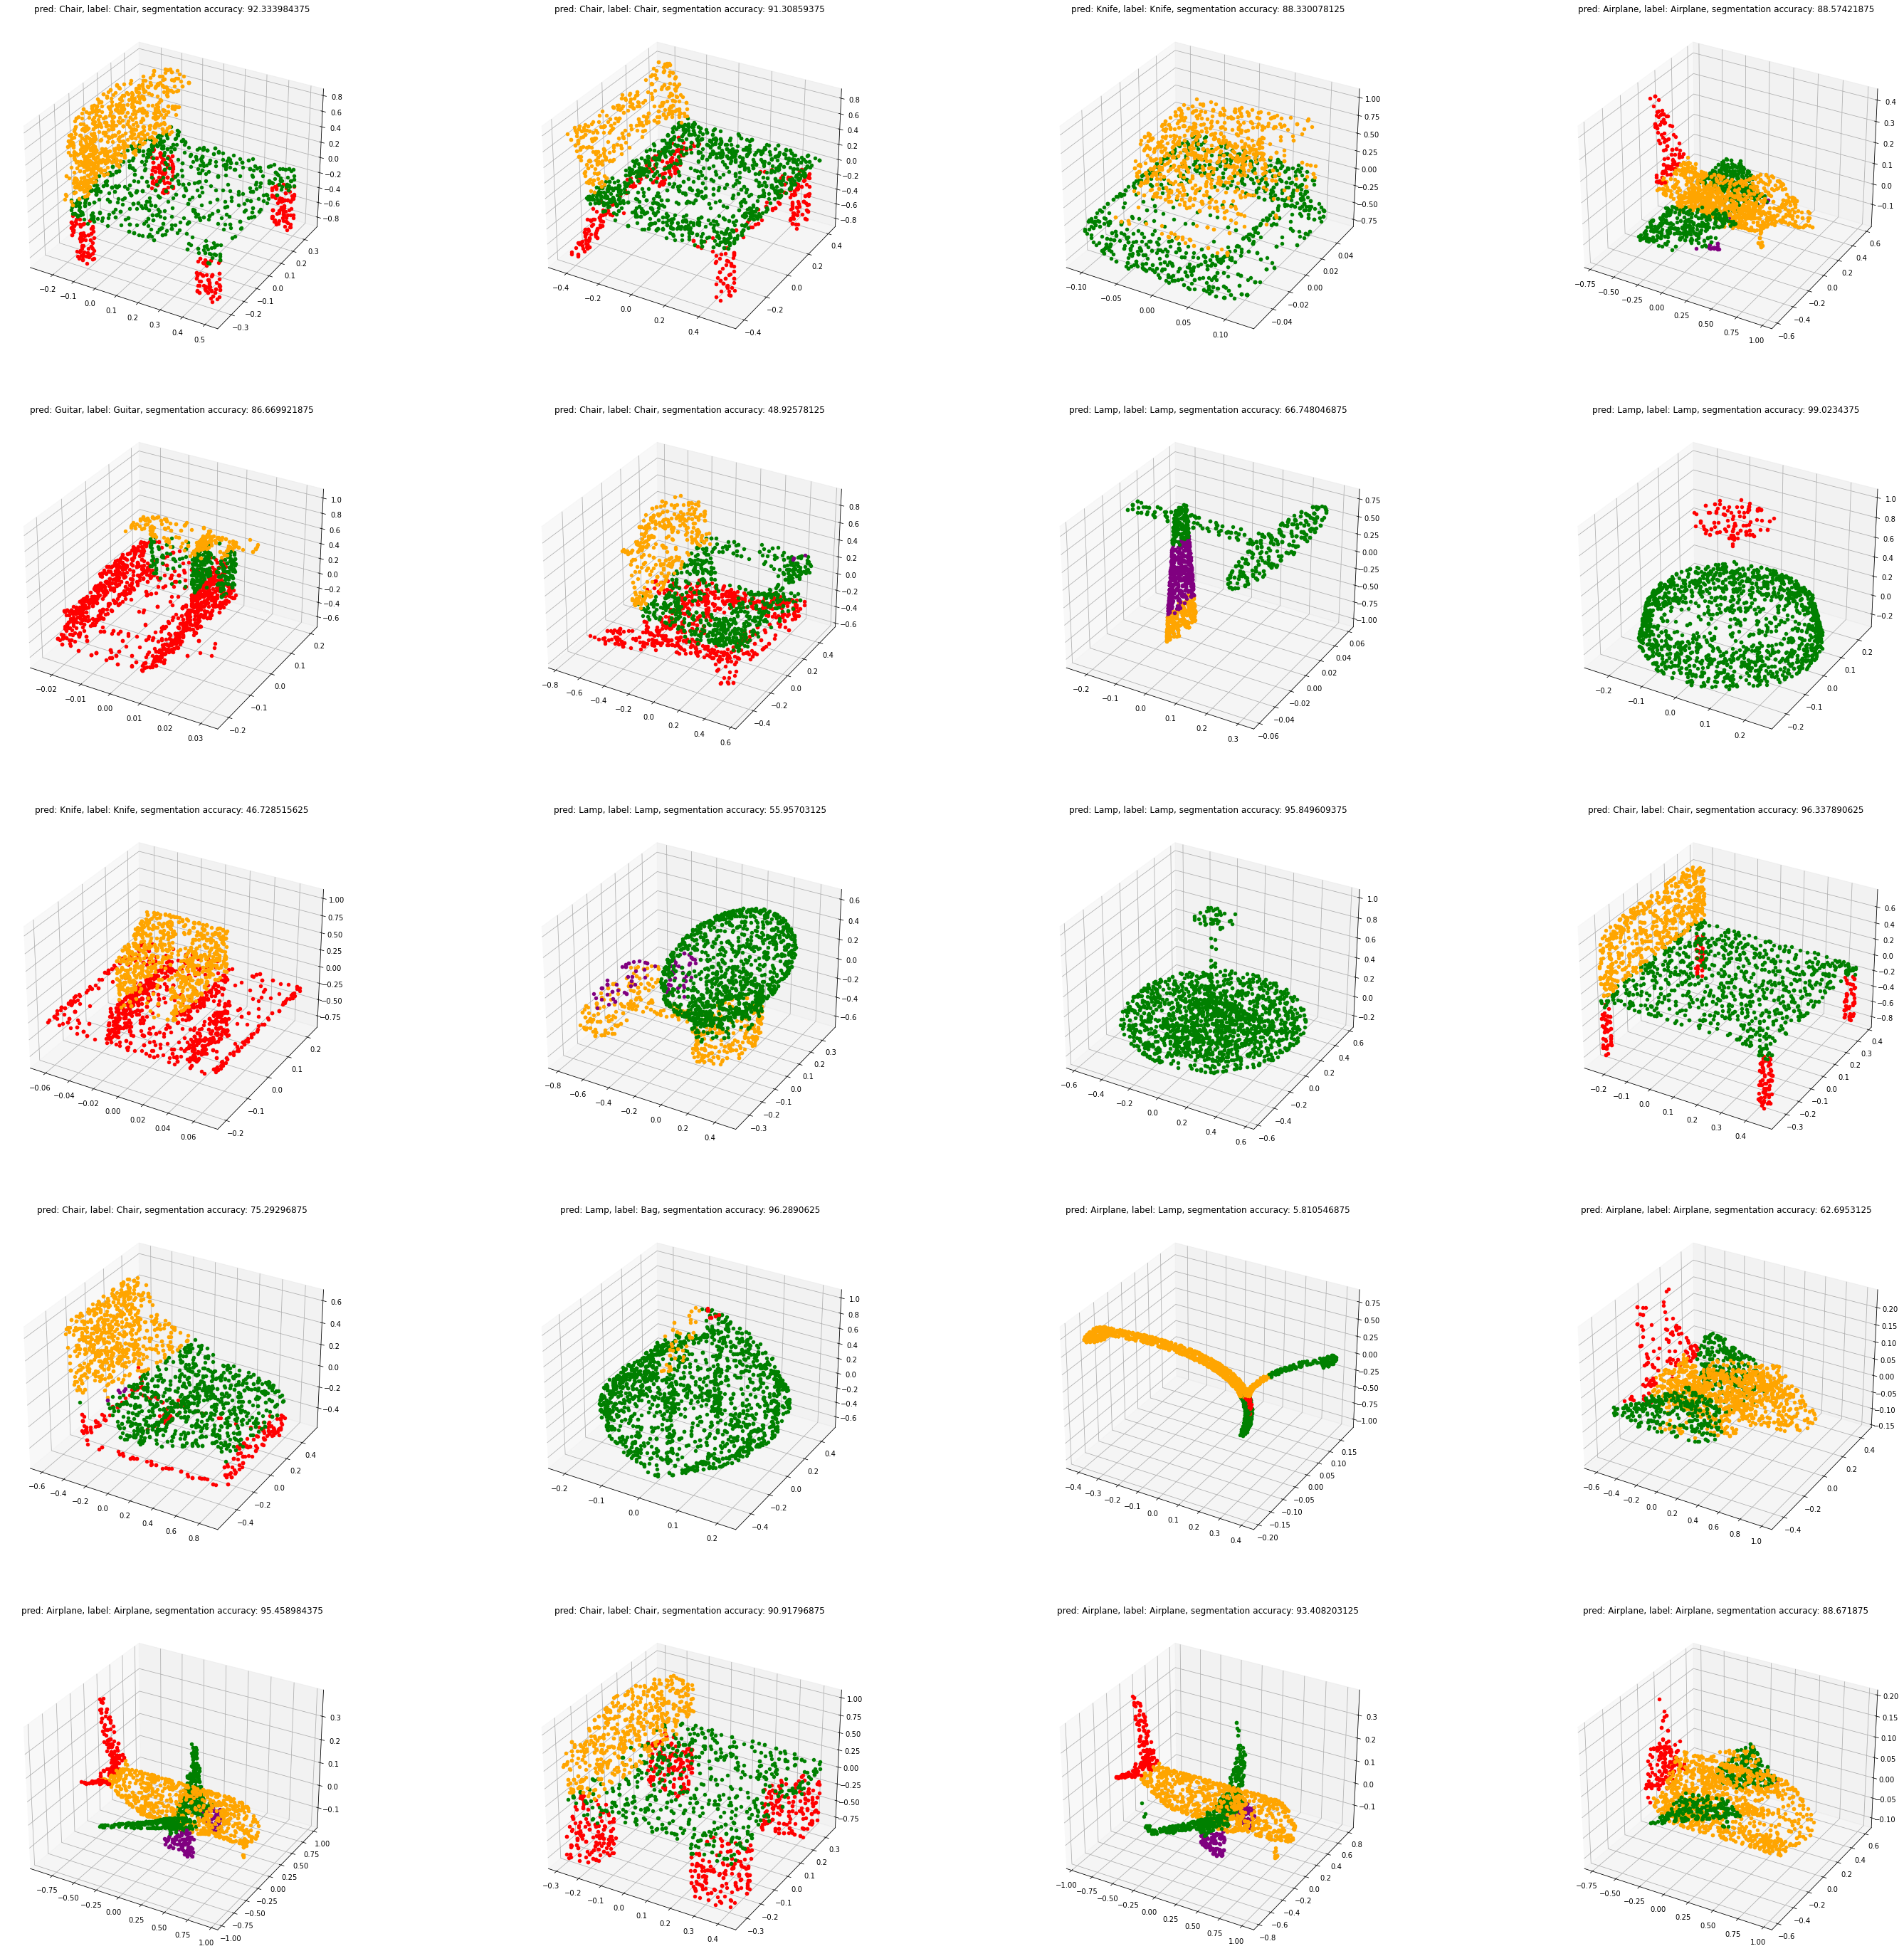

In [50]:
from matplotlib import pyplot as plt

'''
points = points.to('cpu').numpy()
preds = preds.to('cpu')
labels = labels.to('cpu')
'''

corr_seg = 0

max_elements, max_idxs = torch.max(feat_map, dim = 2)
seg_points = max_idxs
avg_acc = 0
acc_lst = []

for i in range(20):
    corr_seg = 0
    for j in range(2048):
        if(seg_points[i][j] == feats[i][j]):
            corr_seg += 1
    acc = corr_seg/(2048) *100
    acc_lst.append(acc)
    avg_acc += acc
avg_acc /=20
print('average segmentation accuracy is: ', ("%.4g" % avg_acc ),'%')

        
color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan']
obj = points[0]

fig = plt.figure(figsize=(50, 50))
for j in range(20):
    obj = points[j]
    ax = fig.add_subplot(5, 4, j + 1, projection="3d")
    acc = acc_lst[j]
    ax.set_title(
        "pred: {:}, label: {:}, segmentation accuracy: {:}".format(
            CLASS_MAP[int(preds[j])], CLASS_MAP[int(labels[j])], acc
        )
    )
    for i in range(2048):
        ax.scatter(obj[0][i], obj[2][i], obj[1][i], color = color[seg_points[j][i]])

plt.show()